In [4]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load your dataset (replace with actual file path if needed)
data = pd.read_csv(r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\processed\emotion_augmented.csv")   # or the actual file you used

# Extract inputs and labels
messages = data['text'].values       # column with student messages
labels = data['emotion'].values      # column with emotion labels

# 2. Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(messages)

# 3. Convert text → sequences of integers
sequences = tokenizer.texts_to_sequences(messages)

# 4. Pad / truncate sequences so they all have same length
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')

# Check output
print("Example original:", messages[0])
print("Tokenized sequence:", sequences[0])
print("Padded sequence:", padded_sequences[0])


Example original: finally passed exam stressed
Tokenized sequence: [42, 133, 9, 559]
Padded sequence: [ 42 133   9 559   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [6]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load augmented dataset
data = pd.read_csv(r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\processed\emotion_augmented.csv")

# Extract labels
labels = data['emotion'].values

# 1️⃣ Convert string labels to integer labels
le = LabelEncoder()
integer_labels = le.fit_transform(labels)
print("Classes:", le.classes_)
print("Integer labels example:", integer_labels[:5])

# 2️⃣ Convert integer labels → one-hot encoding
one_hot_labels = to_categorical(integer_labels)
print("One-hot encoded labels shape:", one_hot_labels.shape)
print("One-hot encoded example:\n", one_hot_labels[:5])

# Save encoder classes for later use (optional)
import pickle
with open(r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\artifacts\label_encoder.pkl", 'wb') as f:
    pickle.dump(le, f)


Classes: ['Anger' 'Fear' 'Joy' 'Neutral' 'Sadness']
Integer labels example: [2 2 2 2 2]
One-hot encoded labels shape: (1520, 5)
One-hot encoded example:
 [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Load your augmented dataset
data = pd.read_csv(r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\processed\emotion_augmented.csv")

# Inputs and labels
messages = data['text'].values
labels = data['emotion'].values

# One-hot encode the labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
integer_labels = le.fit_transform(labels)
y = to_categorical(integer_labels)  # Convert to one-hot

# Split into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(messages, y, test_size=0.2, random_state=42)

print(f"✅ Train samples: {len(X_train)}, Test samples: {len(X_test)}")

✅ Train samples: 1216, Test samples: 304


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # fit on train data only

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 50
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print("✅ Example padded sequence:\n", X_train_padded[0])

✅ Example padded sequence:
 [179 109  73 996   7  57   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [3]:
# ---------------------------
# 0. Imports
# ---------------------------
import pandas as pd
import numpy as np
import nltk
import random
from nltk.corpus import wordnet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pickle

# ---------------------------
# 1. Load Dataset
# ---------------------------
file_path = r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\processed\emotion_augmented.csv"
df = pd.read_csv(file_path)
df['text'] = df['text'].astype(str)
messages = df['text'].values
labels = df['emotion'].values

# ---------------------------
# 2. Data Augmentation (Synonym Replacement)
# ---------------------------
nltk.download('wordnet')
nltk.download('omw-1.4')

def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            if synonym != random_word:
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

augmented_texts = []
augmented_labels = []

for idx, row in df.iterrows():
    augmented_texts.append(row['text'])
    augmented_labels.append(row['emotion'])
    for _ in range(2):  # Add 2 augmented versions
        augmented_texts.append(synonym_replacement(row['text'], n=1))
        augmented_labels.append(row['emotion'])

messages = np.array(augmented_texts)
labels = np.array(augmented_labels)

# ---------------------------
# 3. Encode Labels (One-hot)
# ---------------------------
# LabelEncoder converts string labels to integers
le = LabelEncoder()
integer_labels = le.fit_transform(labels)

# One-hot encoding for neural network
y = to_categorical(integer_labels)
num_classes = y.shape[1]

# Save label encoder
le_path = r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\artifacts\label_encoder.pkl"
with open(le_path, 'wb') as f:
    pickle.dump(le, f)
print("✅ label_encoder.pkl saved successfully!")

# ---------------------------
# 4. Tokenize & Pad Sequences
# ---------------------------
vocab_size = 10000
max_length = 50
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(messages)
sequences = tokenizer.texts_to_sequences(messages)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Save tokenizer
tokenizer_path = r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\artifacts\tokenizer.pkl"
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ tokenizer.pkl saved successfully!")

# ---------------------------
# 5. Train/Test Split
# ---------------------------
# 80% train, 20% test (validation split will be done during training)
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 6. Build Bi-LSTM Model
# ---------------------------
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # softmax for multi-class classification
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_length))
model.summary()

# ---------------------------
# 7. Callbacks
# ---------------------------
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# ---------------------------
# 8. Train Model
# ---------------------------
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% of train used for validation
    epochs=15,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ---------------------------
# 9. Evaluate Model
# ---------------------------
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")

# ---------------------------
# 10. Save Model
# ---------------------------
model.save(r"C:\Users\WINDOWS 1O\Desktop\EmotiSense\artifacts\emotion_model_Bi-lstm.keras")
print("✅ Model saved successfully.")


[nltk_data] Downloading package wordnet to C:\Users\WINDOWS
[nltk_data]     1O\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\WINDOWS
[nltk_data]     1O\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


✅ label_encoder.pkl saved successfully!
✅ tokenizer.pkl saved successfully!


C:\Users\WINDOWS 1O\.conda\envs\ed\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,708,165 (6.52 MB)

 Trainable params: 1,708,165 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 320ms/step - accuracy: 0.2781 - loss: 1.5874 - val_accuracy: 0.4959 - val_loss: 1.4174 - learning_rate: 0.0010
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.6960 - loss: 0.8377 - val_accuracy: 0.9041 - val_loss: 0.3764 - learning_rate: 0.0010
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 296ms/step - accuracy: 0.9190 - loss: 0.2824 - val_accuracy: 0.9342 - val_loss: 0.1870 - learning_rate: 0.0010
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.9634 - loss: 0.1342 - val_accuracy: 0.9644 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.9811 - loss: 0.0678 - val_accuracy: 0.9644 - val_loss: 0.0993 - learning_rate: 0.0010
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - accuracy: 0.9909 - loss: 0.0393 - val_accuracy: 0.9753 - val_loss: 0.0863 - learning_rate: 0.0010
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.9909 - loss: 0.

In [4]:
# Print final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"✅ Final Training Accuracy: {final_train_acc:.4f}")
print(f"✅ Final Validation Accuracy: {final_val_acc:.4f}")


✅ Final Training Accuracy: 0.9994
✅ Final Validation Accuracy: 0.9808


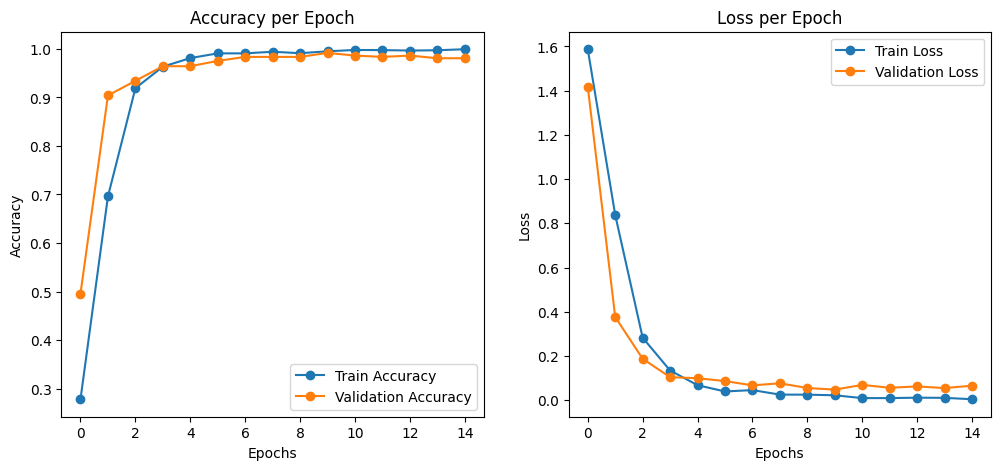

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
